In [1]:
%load_ext autoreload
%autoreload 2

from fastai.text.all import *
from fastai.vision.all import *
import pandas as pd
import torch
from tqdm.notebook import tqdm
from sklearn.metrics import classification_report, f1_score
from torchcrf import CRF

In [2]:
seed = 42

# python RNG
import random
random.seed(seed)

# pytorch RNGs
import torch
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
if torch.cuda.is_available(): torch.cuda.manual_seed_all(seed)

# numpy RNG
import numpy as np
np.random.seed(seed)

In [3]:
OUT_DIM=12
INPUT_DIM=128
BS= 64

In [5]:
train = pd.read_csv("./data/train_fusion.csv")
val = pd.read_csv("./data/val_fusion.csv")
test_data = pd.read_csv("./data/test_fusion.csv")

In [6]:
train["document_type"] = train.apply(lambda x: "B-" + x["document_type"] if x["pages"] == 1 else "I-" + x["document_type"],
                                     axis=1)
val["document_type"] = val.apply(lambda x: "B-" + x["document_type"] if x["pages"] == 1 else "I-" + x["document_type"],
                                     axis=1)
test_data["document_type"] = test_data.apply(lambda x: "B-" + x["document_type"] if x["pages"] == 1 else "I-" + x["document_type"],
                                   axis=1)

In [7]:
def get_sequences(data):
    xs = []
    ys = []
    for k, v in data.groupby("process_id").groups.items():
        xs.append(data.iloc[v]["activation_path"].tolist())
        ys.append(data.iloc[v]["document_type"].tolist())
    return xs, ys

In [8]:
X_train, y_train = get_sequences(train)
X_valid, y_valid = get_sequences(val)
X_test, y_test = get_sequences(test_data)

In [9]:
data = pd.concat([pd.DataFrame({"acts":X_train, "labels":y_train, "is_valid": False}),
                 pd.DataFrame({"acts":X_valid, "labels":y_valid, "is_valid": True})])

In [4]:
class GetFusionActs(Transform):
    def encodes(self, x):    
        acts = []
        for act in x["acts"]:
            acts.append(torch.load(act.replace("text", "fusion") + ".pt").unsqueeze(0)) 
        return torch.cat(acts)

In [5]:
class GetLabels(Transform):
    def setup(self, items, train_setup):
        if train_setup:
            self.cat = Categorize()
            self.cat.setup([x for sublist in items.items["labels"].tolist() for x in sublist])
        
    def encodes(self, x):
        labels = []
        for label in x["labels"]:
            labels.append(self.cat(label).unsqueeze(0).unsqueeze(0))
        return torch.cat(labels)

In [6]:
class My_Pad_Input(ItemTransform):
    def encodes(self,samples, pad_fields=0, pad_first=False, backwards=False):
        "Function that collect `samples` and adds padding"
        pad_fields = L(pad_fields)
        max_len_l = pad_fields.map(lambda f: max([len(s[f]) for s in samples]))
        if backwards: pad_first = not pad_first
        def _f(field_idx, x):
            pad_value=0
            if field_idx not in pad_fields: return x
            if field_idx==1:
                pad_value=OUT_DIM
            idx = pad_fields.items.index(field_idx) #TODO: remove items if L.index is fixed
            sl = slice(-len(x), sys.maxsize) if pad_first else slice(0, len(x))
            pad =  x.new_zeros((max_len_l[idx]-x.shape[0], *x.shape[1:]))+pad_value
            x1 = torch.cat([pad, x] if pad_first else [x, pad])
            if backwards: x1 = x1.flip(0)
            return retain_type(x1, x)
        return [tuple(map(lambda idxx: _f(*idxx), enumerate(s))) for s in samples]
my_pad_input=My_Pad_Input()

In [ ]:
tfms = [[GetFusionActs()], [GetLabels()]]
splits = ColSplitter()(data)
dsets = Datasets(data, tfms, splits=splits)
dls = dsets.dataloaders(dl_type=SortedDL, before_batch=partial(my_pad_input, pad_fields=[0,1]), bs=BS)

In [ ]:
dls.one_batch()

In [14]:
torch.save(dls, "./data/dls_sequence.pth")

In [7]:
dls = torch.load("./data/dls_sequence.pth")

In [175]:
class SequenceModel(Module):
    def __init__(self, hidden_dim=128, out_dim=OUT_DIMz):
        self.lstm = torch.nn.LSTM(input_size=INPUT_DIM, hidden_size=hidden_dim,
                                  batch_first=True, bidirectional=True).cuda()
        self.bn = nn.BatchNorm1d(hidden_dim*2, momentum=0.01).cuda()
        self.drop = nn.Dropout().cuda()
        self.lin = nn.Linear(hidden_dim*2, out_dim).cuda()
        
    def forward(self, x):
        out, _ = self.lstm(x)
        out = out.permute(0, 2, 1)
        out_norm = self.bn(out)
        out_drop = self.drop(out_norm)
        out_drop = out_drop.permute(0, 2, 1)
        return self.lin(out_drop)

In [176]:
model = SequenceModel()

In [8]:
def loss_func(out, targ):
    return CrossEntropyLossFlat(ignore_index=OUT_DIM)(out, targ.long())

In [9]:
def _accumulate(self, learn):
    pred = learn.pred
    targ = learn.y
    pred,targ = to_detach(pred),to_detach(targ)
    pred =np.argmax(pred, axis=-1)
    pred, targ = flatten_check(pred, targ)
    pad_idxs = [i for i,x in enumerate(targ) if x != tensor([12])]
    pred = pred[pad_idxs]
    targ = targ[pad_idxs]
    pred = torch.remainder(pred, 6)
    targ = torch.remainder(targ, 6)
    self.preds.append(pred)
    self.targs.append(targ)

AccumMetric.accumulate = _accumulate

def MyFScore(average='macro'):
    return skm_to_fastai(f1_score, average=average)

In [192]:
learn = Learner(dls, model, loss_func=loss_func, metrics=[MyFScore()])

In [184]:
learn.summary()

SequenceModel (Input shape: ['64 x 4242 x 128'])
Layer (type)         Output Shape         Param #    Trainable 
LSTM                 ['64 x 4242 x 256',  264,192    True      
________________________________________________________________
BatchNorm1d          64 x 256 x 4242      512        True      
________________________________________________________________
Dropout              64 x 256 x 4242      0          False     
________________________________________________________________
Linear               64 x 4242 x 12       3,084      True      
________________________________________________________________

Total params: 267,788
Total trainable params: 267,788
Total non-trainable params: 0

Optimizer used: <function Adam at 0x7fc694c8f430>
Loss function: <function loss_func at 0x7fc544e7b700>

Callbacks:
  - TrainEvalCallback
  - Recorder
  - ProgressCallback

In [ ]:
learn.validate()

SuggestedLRs(lr_min=0.03019951581954956, lr_steep=0.010964781977236271)

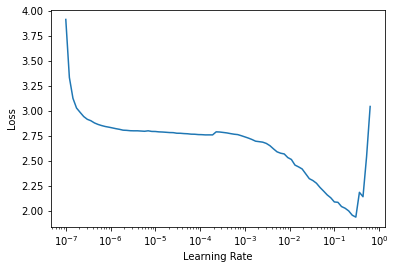

In [185]:
learn.lr_find()

In [193]:
learn.add_cbs([SaveModelCallback(monitor='f1_score', fname='best_sequence_128'),
                                       ShowGraphCallback()])

epoch,train_loss,valid_loss,f1_score,time
0,0.463998,0.624359,0.760527,03:50
1,0.460408,0.635508,0.738585,04:22
2,0.450636,0.646396,0.762600,04:37
3,0.470724,0.638396,0.753507,04:15
4,0.470006,0.689637,0.771371,04:05
5,0.448070,0.621627,0.777340,04:16
6,0.426568,0.613815,0.757561,04:21
7,0.413713,0.635003,0.771453,04:43
8,0.409453,0.622239,0.770163,04:18
9,0.403378,0.618856,0.771595,04:20


Better model found at epoch 0 with f1_score value: 0.7605274235442635.


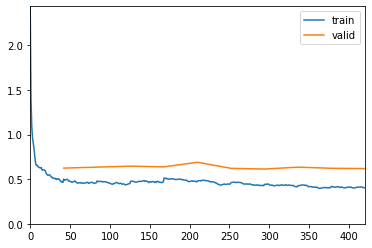

Better model found at epoch 2 with f1_score value: 0.7626003789602782.
Better model found at epoch 4 with f1_score value: 0.7713708215048861.
Better model found at epoch 5 with f1_score value: 0.7773397805989104.


In [194]:
learn.fit_one_cycle(10, lr_max=1e-2)

In [198]:
model = SequenceModel(hidden_dim=256)

In [199]:
learn = Learner(dls, model, loss_func=loss_func, metrics=[MyFScore()])

In [200]:
learn.summary()

SequenceModel (Input shape: ['64 x 4242 x 128'])
Layer (type)         Output Shape         Param #    Trainable 
LSTM                 ['64 x 4242 x 512',  790,528    True      
________________________________________________________________
BatchNorm1d          64 x 512 x 4242      1,024      True      
________________________________________________________________
Dropout              64 x 512 x 4242      0          False     
________________________________________________________________
Linear               64 x 4242 x 12       6,156      True      
________________________________________________________________

Total params: 797,708
Total trainable params: 797,708
Total non-trainable params: 0

Optimizer used: <function Adam at 0x7fc694c8f430>
Loss function: <function loss_func at 0x7fc544e7b700>

Callbacks:
  - TrainEvalCallback
  - Recorder
  - ProgressCallback

SuggestedLRs(lr_min=0.010000000149011612, lr_steep=0.033113110810518265)

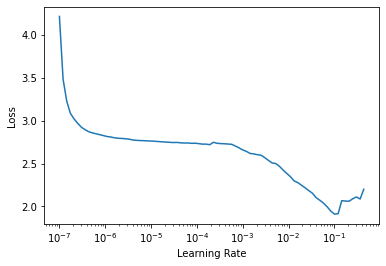

In [201]:
learn.lr_find()

In [202]:
learn.add_cbs([SaveModelCallback(monitor='f1_score', fname='best_sequence_256'),
                                       ShowGraphCallback()])

epoch,train_loss,valid_loss,f1_score,time
0,1.739531,0.731856,0.600024,03:15
1,0.958818,0.864794,0.162174,04:08
2,0.791817,0.549651,0.564314,04:10
3,0.670333,0.681630,0.590426,04:13
4,0.634262,0.739056,0.744369,04:00
5,0.564580,0.626930,0.749589,04:02
6,0.601588,1.455407,0.759692,04:07
7,0.598733,0.928646,0.768330,04:15
8,0.533349,0.800493,0.770257,04:23
9,0.487383,0.773178,0.769277,03:53


Better model found at epoch 0 with f1_score value: 0.6000241358943937.


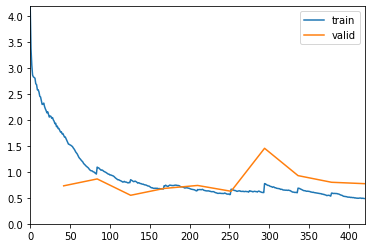

Better model found at epoch 4 with f1_score value: 0.7443691316251758.
Better model found at epoch 5 with f1_score value: 0.7495886360600279.
Better model found at epoch 6 with f1_score value: 0.7596919711375182.
Better model found at epoch 7 with f1_score value: 0.7683303196023269.
Better model found at epoch 8 with f1_score value: 0.7702571801603605.


In [203]:
learn.fit_one_cycle(10, lr_max=1e-2)

In [204]:
model = SequenceModel()

In [205]:
learn = Learner(dls, model, loss_func=loss_func, metrics=[MyFScore()])

In [206]:
learn.summary()

SequenceModel (Input shape: ['64 x 4242 x 128'])
Layer (type)         Output Shape         Param #    Trainable 
LSTM                 ['64 x 4242 x 256',  264,192    True      
________________________________________________________________
BatchNorm1d          64 x 256 x 4242      512        True      
________________________________________________________________
Dropout              64 x 256 x 4242      0          False     
________________________________________________________________
Linear               64 x 4242 x 12       3,084      True      
________________________________________________________________

Total params: 267,788
Total trainable params: 267,788
Total non-trainable params: 0

Optimizer used: <function Adam at 0x7fc694c8f430>
Loss function: <function loss_func at 0x7fc544e7b700>

Callbacks:
  - TrainEvalCallback
  - Recorder
  - ProgressCallback

SuggestedLRs(lr_min=0.03019951581954956, lr_steep=0.010964781977236271)

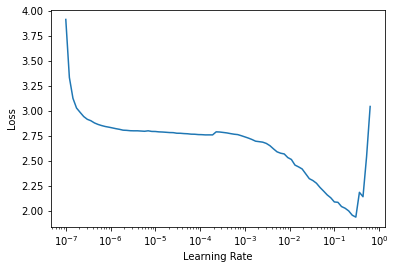

In [185]:
learn.lr_find()

In [207]:
learn.add_cbs([SaveModelCallback(monitor='f1_score', fname='best_sequence_128_more_epochs'),
                                       ShowGraphCallback()])

epoch,train_loss,valid_loss,f1_score,time
0,2.185531,1.216205,0.634767,03:55
1,1.481416,0.766167,0.618348,04:18
2,0.945172,0.653605,0.603354,04:32
3,0.702862,0.641554,0.689114,04:13
4,0.608428,0.638108,0.575528,04:16
5,0.565160,0.676345,0.724108,04:18
6,0.530399,0.587832,0.750578,04:11
7,0.569292,0.605112,0.736566,04:26
8,0.540357,0.652844,0.740394,04:20
9,0.488475,0.790486,0.750856,04:35


Better model found at epoch 0 with f1_score value: 0.6347667433703132.


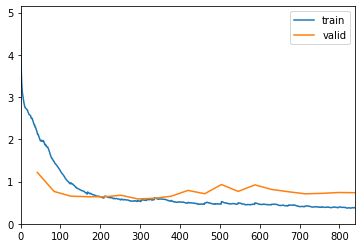

Better model found at epoch 3 with f1_score value: 0.6891135856929514.
Better model found at epoch 5 with f1_score value: 0.7241083182116529.
Better model found at epoch 6 with f1_score value: 0.7505783263290399.
Better model found at epoch 9 with f1_score value: 0.7508555472414002.
Better model found at epoch 10 with f1_score value: 0.7729201568848018.
Better model found at epoch 12 with f1_score value: 0.7798754984648039.


In [208]:
learn.fit_one_cycle(20, lr_max=1e-2)

In [ ]:
learn.load("best_sequence_128_more_epochs")

In [94]:
def evaluate(learn, dl):
    preds, targets = learn.get_preds(dl=dl)
    preds =[np.argmax(x, axis=-1) for sublist in preds for x in sublist]
    targets = [x for sublist in targets for x in sublist]
    pad_idxs = [i for i,x in enumerate(targets) if x != tensor([12])]
    preds = L(preds)[pad_idxs]
    targets = L(targets)[pad_idxs]
    print(classification_report(targets, preds, target_names=dl.get_labels.cat.vocab, digits=4))
    preds = [x % 6 for x in preds]
    targets = [x % 6 for x in targets]
    print(classification_report(targets, preds, target_names=[x[2:] for x in dl.get_labels.cat.vocab[:6]], digits=4))

In [221]:
evaluate(learn, dls.valid)

                                    precision    recall  f1-score   support

          B-acordao_de_2_instancia     0.8571    0.1194    0.2096       201
B-agravo_em_recurso_extraordinario     0.4737    0.0380    0.0703       237
     B-despacho_de_admissibilidade     0.6331    0.7279    0.6772       147
                          B-outros     0.7241    0.4985    0.5904     25898
                   B-peticao_do_RE     0.0833    0.0031    0.0059       326
                        B-sentenca     1.0000    0.0035    0.0070       284
          I-acordao_de_2_instancia     0.2596    0.6224    0.3664        98
I-agravo_em_recurso_extraordinario     0.5743    0.5701    0.5722      1912
     I-despacho_de_admissibilidade     0.0000    0.0000    0.0000        36
                          I-outros     0.7718    0.8810    0.8228     58206
                   I-peticao_do_RE     0.7054    0.7761    0.7391      6038
                        I-sentenca     0.7043    0.7611    0.7316      1352

          

In [212]:
test_data = pd.DataFrame({"acts":X_test, "labels":y_test})

In [213]:
test_dl = dls.test_dl(test_data, with_labels=True)

In [216]:
torch.save(test_dl, "./data/test_dl_sequence.pth")

In [222]:
evaluate(learn, test_dl)

                                    precision    recall  f1-score   support

          B-acordao_de_2_instancia     0.9143    0.1608    0.2735       199
B-agravo_em_recurso_extraordinario     0.2258    0.0329    0.0574       213
     B-despacho_de_admissibilidade     0.5500    0.6735    0.6055       147
                          B-outros     0.7043    0.4848    0.5743     25744
                   B-peticao_do_RE     0.0556    0.0032    0.0061       312
                        B-sentenca     0.0000    0.0000    0.0000       265
          I-acordao_de_2_instancia     0.2696    0.8378    0.4079        74
I-agravo_em_recurso_extraordinario     0.5551    0.5565    0.5558      1628
     I-despacho_de_admissibilidade     0.0000    0.0000    0.0000        51
                          I-outros     0.7747    0.8835    0.8255     59664
                   I-peticao_do_RE     0.7270    0.7586    0.7424      6019
                        I-sentenca     0.6925    0.7760    0.7319      1210

          

### With CRF

In [152]:
class BiLSTMCRF(Module):
    def __init__(self, hidden_dim=128, out_dim=OUT_DIM):
        self.lstm = torch.nn.LSTM(input_size=INPUT_DIM, hidden_size=hidden_dim,
                                  batch_first=True, bidirectional=True).cuda()
        self.bn = nn.BatchNorm1d(hidden_dim*2, momentum=0.01).cuda()
        self.drop = nn.Dropout().cuda()
        self.lin = nn.Linear(hidden_dim*2, out_dim).cuda()
        self.crf = CRF(num_tags=OUT_DIM, batch_first=True).cuda()
            
    def crf_loss_func(self, out, targ):
        mask = tensor(targ.data != OUT_DIM)
        targ[targ==OUT_DIM]=0
        targ=targ.view(out.shape[:2])
        mask=mask.view(targ.shape)
        return -self.crf(out, targ.long(), mask=mask, reduction="mean")
        
    def forward(self, x):
        out, _ = self.lstm(x)
        out = out.permute(0, 2, 1)
        out_norm = self.bn(out)
        out_drop = self.drop(out_norm)
        out_drop = out_drop.permute(0, 2, 1)
        logits = self.lin(out_drop)
        return logits

In [153]:
model = BiLSTMCRF()

In [154]:
def _accumulate(self, learn):
    pred = learn.pred
    targ = learn.y
    mask = tensor(targ.data != OUT_DIM)
    pred,targ, mask = to_detach(pred),to_detach(targ), to_detach(mask)
    mask=mask.view(pred.shape[:2])
    pred = learn.model.crf.decode(pred.cuda(),mask=mask.cuda())
    pred = tensor([[x for sublist in pred for x in sublist]]).view(-1)
    targ = targ[mask].view(-1)
    pred = torch.remainder(pred, 6)
    targ = torch.remainder(targ, 6)
    self.preds.append(pred)
    self.targs.append(targ)

AccumMetric.accumulate = _accumulate

def MyFScore(average='macro'):
    return skm_to_fastai(f1_score, average=average)

In [155]:
learn = Learner(dls, model, loss_func=model.crf_loss_func, metrics=[MyFScore()])

In [ ]:
learn.validate()

In [ ]:
learn.summary()

In [ ]:
learn.lr_find()

In [ ]:
learn.add_cbs([SaveModelCallback(monitor='f1_score', fname='best_lstm_crf_128'),
                                       ShowGraphCallback()])

In [ ]:
learn.fit_one_cycle(10, lr_max=1e-2)